In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(2)
epochs = 10
batch_size = 128
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-13 16:25:04,358 [DEBUG] kashgari - ------------------------------------------------
2020-12-13 16:25:04,359 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-13 16:25:04,359 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-13 16:25:04,360 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-13 16:25:04,360 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-13 16:25:04,360 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/10
380/380 [==============================] - 49s 129ms/step - loss: 0.4832 - accuracy: 0.9764 - val_loss: 23.4784 - val_accuracy: 0.9885
Epoch 2/10
380/380 [==============================] - 46s 121ms/step - loss: 0.1711 - accuracy: 0.9882 - val_loss: 23.0201 - val_accuracy: 0.9904
Epoch 3/10
380/380 [==============================] - 47s 123ms/step - loss: 0.1302 - accuracy: 0.9898 - val_loss: 22.5772 - val_accuracy: 0.9904
Epoch 4/10
380/380 [==============================] - 46s 121ms/step - loss: 0.1048 - accuracy: 0.9910 - val_loss: 22.1175 - val_accuracy: 0.9900
Epoch 5/10
380/380 [==============================] - 46s 122ms/step - loss: 0.0864 - accuracy: 0.9919 - val_loss: 21.7086 - val_accuracy: 0.9880
Epoch 6/10
380/380 [==============================] - 47s 124ms/step - loss: 0.0713 - accuracy: 0.9928 - val_loss: 21.2928 - val_accuracy: 0.9852
Epoch 7/10
380/380 [==============================] - 46s 120ms/step - loss: 0.0598 - accuracy: 0.9938 - val_loss: 20.9231 -

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-13 16:33:08,294 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-13 16:33:08,416 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 39s 81ms/step


2020-12-13 16:33:52,284 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-13 16:33:52,285 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8164    0.7802    0.7979       878
      med_exam     0.8542    0.9179    0.8849       134
    profession     0.7000    0.4118    0.5185        17
      location     0.9135    0.9314    0.9223       102
          name     0.9294    0.8977    0.9133        88
         money     0.8511    0.9302    0.8889        43
  organization     0.3333    0.5000    0.4000         2
     education     1.0000    0.5000    0.6667         2
clinical_event     0.0000    0.0000    0.0000         1
       contact     0.7500    0.5000    0.6000        18
        others     0.0000    0.0000    0.0000         1
            ID     0.7500    0.3333    0.4615         9
        family     0.8571    0.5455    0.6667        11

     micro avg     0.8352    0.8032    0.8189      1306
     macro avg     0.8324    0.8032    0.8155      1306



2020-12-13 16:34:02,681 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-10'

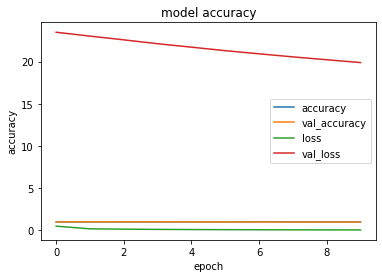

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [16]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-13 16:34:02,801 [DEBUG] kashgari - predict seq_length: None, input: (2, 368, 29)


12/12 [==============================] - 0s 40ms/step


2020-12-13 16:34:06,353 [DEBUG] kashgari - predict output: (368, 29)
2020-12-13 16:34:06,353 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:06,355 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 33)


3/3 [==============================] - 0s 29ms/step


2020-12-13 16:34:09,313 [DEBUG] kashgari - predict output: (78, 33)
2020-12-13 16:34:09,313 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-13 16:34:09,317 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 29)


5/5 [==============================] - 0s 37ms/step


2020-12-13 16:34:09,578 [DEBUG] kashgari - predict output: (159, 29)
2020-12-13 16:34:09,578 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:09,583 [DEBUG] kashgari - predict seq_length: None, input: (2, 329, 28)


11/11 [==============================] - 0s 37ms/step


2020-12-13 16:34:13,005 [DEBUG] kashgari - predict output: (329, 28)
2020-12-13 16:34:13,006 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:13,009 [DEBUG] kashgari - predict seq_length: None, input: (2, 227, 29)


8/8 [==============================] - 0s 34ms/step


2020-12-13 16:34:13,342 [DEBUG] kashgari - predict output: (227, 29)
2020-12-13 16:34:13,343 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 7 4 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:13,347 [DEBUG] kashgari - predict seq_length: None, input: (2, 295, 26)


10/10 [==============================] - 0s 44ms/step


2020-12-13 16:34:16,964 [DEBUG] kashgari - predict output: (295, 26)
2020-12-13 16:34:16,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:16,968 [DEBUG] kashgari - predict seq_length: None, input: (2, 183, 25)


6/6 [==============================] - 0s 41ms/step


2020-12-13 16:34:21,916 [DEBUG] kashgari - predict output: (183, 25)
2020-12-13 16:34:21,917 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:21,919 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 19)


4/4 [==============================] - 0s 34ms/step


2020-12-13 16:34:26,681 [DEBUG] kashgari - predict output: (126, 19)
2020-12-13 16:34:26,682 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:26,684 [DEBUG] kashgari - predict seq_length: None, input: (2, 117, 23)


4/4 [==============================] - 0s 34ms/step


2020-12-13 16:34:31,556 [DEBUG] kashgari - predict output: (117, 23)
2020-12-13 16:34:31,557 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:31,558 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 22)


3/3 [==============================] - 0s 24ms/step


2020-12-13 16:34:34,875 [DEBUG] kashgari - predict output: (91, 22)
2020-12-13 16:34:34,876 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:34,878 [DEBUG] kashgari - predict seq_length: None, input: (2, 63, 25)


2/2 [==============================] - 0s 21ms/step


2020-12-13 16:34:34,983 [DEBUG] kashgari - predict output: (63, 25)
2020-12-13 16:34:34,983 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:34,987 [DEBUG] kashgari - predict seq_length: None, input: (2, 259, 32)


9/9 [==============================] - 0s 39ms/step


2020-12-13 16:34:38,245 [DEBUG] kashgari - predict output: (259, 32)
2020-12-13 16:34:38,246 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 7 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:38,247 [DEBUG] kashgari - predict seq_length: None, input: (2, 109, 20)


4/4 [==============================] - 0s 25ms/step


2020-12-13 16:34:41,218 [DEBUG] kashgari - predict output: (109, 20)
2020-12-13 16:34:41,219 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:41,222 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 22)


4/4 [==============================] - 0s 28ms/step


2020-12-13 16:34:41,390 [DEBUG] kashgari - predict output: (122, 22)
2020-12-13 16:34:41,391 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:41,394 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 40)


5/5 [==============================] - 0s 47ms/step


2020-12-13 16:34:44,520 [DEBUG] kashgari - predict output: (158, 40)
2020-12-13 16:34:44,521 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]]
2020-12-13 16:34:44,525 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 34)


7/7 [==============================] - 0s 44ms/step


2020-12-13 16:34:47,717 [DEBUG] kashgari - predict output: (218, 34)
2020-12-13 16:34:47,718 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:47,722 [DEBUG] kashgari - predict seq_length: None, input: (2, 103, 16)


4/4 [==============================] - 0s 23ms/step


2020-12-13 16:34:50,654 [DEBUG] kashgari - predict output: (103, 16)
2020-12-13 16:34:50,655 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]]
2020-12-13 16:34:50,661 [DEBUG] kashgari - predict seq_length: None, input: (2, 310, 40)


10/10 [==============================] - 0s 48ms/step


2020-12-13 16:34:51,220 [DEBUG] kashgari - predict output: (310, 40)
2020-12-13 16:34:51,220 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:51,222 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 22)


3/3 [==============================] - 0s 21ms/step


2020-12-13 16:34:51,337 [DEBUG] kashgari - predict output: (73, 22)
2020-12-13 16:34:51,338 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:51,349 [DEBUG] kashgari - predict seq_length: None, input: (2, 624, 50)


20/20 [==============================] - 1s 60ms/step


2020-12-13 16:34:55,874 [DEBUG] kashgari - predict output: (624, 50)
2020-12-13 16:34:55,875 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:55,880 [DEBUG] kashgari - predict seq_length: None, input: (2, 445, 35)


14/14 [==============================] - 1s 45ms/step


2020-12-13 16:34:59,467 [DEBUG] kashgari - predict output: (445, 35)
2020-12-13 16:34:59,468 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 3 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:34:59,472 [DEBUG] kashgari - predict seq_length: None, input: (2, 357, 34)


12/12 [==============================] - 0s 40ms/step


2020-12-13 16:35:00,020 [DEBUG] kashgari - predict output: (357, 34)
2020-12-13 16:35:00,021 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:00,026 [DEBUG] kashgari - predict seq_length: None, input: (2, 328, 49)


11/11 [==============================] - 1s 58ms/step


2020-12-13 16:35:03,541 [DEBUG] kashgari - predict output: (328, 49)
2020-12-13 16:35:03,542 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:03,544 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 59)


5/5 [==============================] - 0s 55ms/step


2020-12-13 16:35:06,618 [DEBUG] kashgari - predict output: (133, 59)
2020-12-13 16:35:06,619 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:06,621 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 23)


5/5 [==============================] - 0s 27ms/step


2020-12-13 16:35:06,811 [DEBUG] kashgari - predict output: (129, 23)
2020-12-13 16:35:06,811 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:06,814 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 30)


5/5 [==============================] - 0s 33ms/step


2020-12-13 16:35:09,771 [DEBUG] kashgari - predict output: (131, 30)
2020-12-13 16:35:09,772 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:09,777 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 34)


8/8 [==============================] - 0s 38ms/step


2020-12-13 16:35:10,153 [DEBUG] kashgari - predict output: (234, 34)
2020-12-13 16:35:10,154 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:10,155 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 33)


3/3 [==============================] - 0s 26ms/step


2020-12-13 16:35:10,298 [DEBUG] kashgari - predict output: (79, 33)
2020-12-13 16:35:10,299 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:10,304 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 37)


9/9 [==============================] - 0s 44ms/step


2020-12-13 16:35:13,620 [DEBUG] kashgari - predict output: (260, 37)
2020-12-13 16:35:13,621 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:13,624 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 35)


8/8 [==============================] - 0s 40ms/step


2020-12-13 16:35:14,017 [DEBUG] kashgari - predict output: (255, 35)
2020-12-13 16:35:14,017 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:14,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 175, 41)


6/6 [==============================] - 0s 47ms/step


2020-12-13 16:35:17,838 [DEBUG] kashgari - predict output: (175, 41)
2020-12-13 16:35:17,839 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:17,842 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 31)


6/6 [==============================] - 0s 40ms/step


2020-12-13 16:35:20,999 [DEBUG] kashgari - predict output: (189, 31)
2020-12-13 16:35:21,000 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:21,004 [DEBUG] kashgari - predict seq_length: None, input: (2, 292, 31)


10/10 [==============================] - 0s 37ms/step


2020-12-13 16:35:21,447 [DEBUG] kashgari - predict output: (292, 31)
2020-12-13 16:35:21,447 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:21,450 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 38)


4/4 [==============================] - 0s 34ms/step


2020-12-13 16:35:24,495 [DEBUG] kashgari - predict output: (97, 38)
2020-12-13 16:35:24,496 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:24,501 [DEBUG] kashgari - predict seq_length: None, input: (2, 351, 56)


11/11 [==============================] - 1s 66ms/step


2020-12-13 16:35:28,167 [DEBUG] kashgari - predict output: (351, 56)
2020-12-13 16:35:28,168 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:28,172 [DEBUG] kashgari - predict seq_length: None, input: (2, 297, 46)


10/10 [==============================] - 1s 57ms/step


2020-12-13 16:35:31,475 [DEBUG] kashgari - predict output: (297, 46)
2020-12-13 16:35:31,475 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:31,478 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 21)


5/5 [==============================] - 0s 37ms/step


2020-12-13 16:35:35,688 [DEBUG] kashgari - predict output: (136, 21)
2020-12-13 16:35:35,689 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:35,691 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 42)


4/4 [==============================] - 0s 50ms/step


2020-12-13 16:35:40,506 [DEBUG] kashgari - predict output: (115, 42)
2020-12-13 16:35:40,506 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:40,509 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 23)


3/3 [==============================] - 0s 33ms/step


2020-12-13 16:35:40,683 [DEBUG] kashgari - predict output: (89, 23)
2020-12-13 16:35:40,684 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:40,688 [DEBUG] kashgari - predict seq_length: None, input: (2, 251, 52)


8/8 [==============================] - 1s 71ms/step


2020-12-13 16:35:46,018 [DEBUG] kashgari - predict output: (251, 52)
2020-12-13 16:35:46,019 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:46,022 [DEBUG] kashgari - predict seq_length: None, input: (2, 153, 20)


5/5 [==============================] - 0s 33ms/step


2020-12-13 16:35:46,253 [DEBUG] kashgari - predict output: (153, 20)
2020-12-13 16:35:46,253 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ... 22 22 22]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-13 16:35:46,256 [DEBUG] kashgari - predict seq_length: None, input: (2, 169, 47)


6/6 [==============================] - 0s 53ms/step


2020-12-13 16:35:50,541 [DEBUG] kashgari - predict output: (169, 47)
2020-12-13 16:35:50,542 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:50,546 [DEBUG] kashgari - predict seq_length: None, input: (2, 324, 37)


11/11 [==============================] - 0s 44ms/step


2020-12-13 16:35:51,107 [DEBUG] kashgari - predict output: (324, 37)
2020-12-13 16:35:51,107 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:51,110 [DEBUG] kashgari - predict seq_length: None, input: (2, 157, 35)


5/5 [==============================] - 0s 38ms/step


2020-12-13 16:35:51,371 [DEBUG] kashgari - predict output: (157, 35)
2020-12-13 16:35:51,372 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:51,376 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 27)


6/6 [==============================] - 0s 38ms/step


2020-12-13 16:35:54,558 [DEBUG] kashgari - predict output: (191, 27)
2020-12-13 16:35:54,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:54,561 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 36)


4/4 [==============================] - 0s 39ms/step


2020-12-13 16:35:57,678 [DEBUG] kashgari - predict output: (115, 36)
2020-12-13 16:35:57,678 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:57,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 529, 33)


17/17 [==============================] - 1s 42ms/step


2020-12-13 16:35:58,478 [DEBUG] kashgari - predict output: (529, 33)
2020-12-13 16:35:58,479 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:58,482 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 32)


7/7 [==============================] - 0s 37ms/step


2020-12-13 16:35:58,810 [DEBUG] kashgari - predict output: (217, 32)
2020-12-13 16:35:58,811 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:58,814 [DEBUG] kashgari - predict seq_length: None, input: (2, 186, 47)


6/6 [==============================] - 0s 51ms/step


2020-12-13 16:35:59,204 [DEBUG] kashgari - predict output: (186, 47)
2020-12-13 16:35:59,205 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:35:59,209 [DEBUG] kashgari - predict seq_length: None, input: (2, 410, 55)


13/13 [==============================] - 1s 65ms/step


2020-12-13 16:36:03,021 [DEBUG] kashgari - predict output: (410, 55)
2020-12-13 16:36:03,022 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:03,026 [DEBUG] kashgari - predict seq_length: None, input: (2, 347, 42)


11/11 [==============================] - 1s 48ms/step


2020-12-13 16:36:03,635 [DEBUG] kashgari - predict output: (347, 42)
2020-12-13 16:36:03,636 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:03,642 [DEBUG] kashgari - predict seq_length: None, input: (2, 524, 65)


17/17 [==============================] - 1s 80ms/step


2020-12-13 16:36:05,118 [DEBUG] kashgari - predict output: (524, 65)
2020-12-13 16:36:05,120 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:05,124 [DEBUG] kashgari - predict seq_length: None, input: (2, 182, 29)


6/6 [==============================] - 0s 39ms/step


2020-12-13 16:36:05,427 [DEBUG] kashgari - predict output: (182, 29)
2020-12-13 16:36:05,427 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:05,431 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 20)


6/6 [==============================] - 0s 25ms/step


2020-12-13 16:36:05,633 [DEBUG] kashgari - predict output: (163, 20)
2020-12-13 16:36:05,633 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:05,635 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 19)


4/4 [==============================] - 0s 47ms/step


2020-12-13 16:36:05,919 [DEBUG] kashgari - predict output: (97, 19)
2020-12-13 16:36:05,920 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:05,924 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 21)


6/6 [==============================] - 0s 59ms/step


2020-12-13 16:36:06,374 [DEBUG] kashgari - predict output: (189, 21)
2020-12-13 16:36:06,374 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:06,379 [DEBUG] kashgari - predict seq_length: None, input: (2, 320, 25)


10/10 [==============================] - 0s 47ms/step


2020-12-13 16:36:08,975 [DEBUG] kashgari - predict output: (320, 25)
2020-12-13 16:36:08,976 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:08,979 [DEBUG] kashgari - predict seq_length: None, input: (2, 301, 20)


10/10 [==============================] - 1s 59ms/step


2020-12-13 16:36:09,646 [DEBUG] kashgari - predict output: (301, 20)
2020-12-13 16:36:09,646 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0 10  6 ...  6  6  6]
 ...
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-13 16:36:09,649 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 35)


3/3 [==============================] - 0s 55ms/step


2020-12-13 16:36:09,925 [DEBUG] kashgari - predict output: (82, 35)
2020-12-13 16:36:09,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:09,929 [DEBUG] kashgari - predict seq_length: None, input: (2, 192, 37)


6/6 [==============================] - 0s 64ms/step


2020-12-13 16:36:12,406 [DEBUG] kashgari - predict output: (192, 37)
2020-12-13 16:36:12,406 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 3 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:12,410 [DEBUG] kashgari - predict seq_length: None, input: (2, 264, 48)


9/9 [==============================] - 1s 102ms/step


2020-12-13 16:36:16,429 [DEBUG] kashgari - predict output: (264, 48)
2020-12-13 16:36:16,430 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:16,435 [DEBUG] kashgari - predict seq_length: None, input: (2, 247, 43)


8/8 [==============================] - 1s 94ms/step


2020-12-13 16:36:20,202 [DEBUG] kashgari - predict output: (247, 43)
2020-12-13 16:36:20,203 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:20,205 [DEBUG] kashgari - predict seq_length: None, input: (2, 120, 21)


4/4 [==============================] - 0s 51ms/step


2020-12-13 16:36:20,500 [DEBUG] kashgari - predict output: (120, 21)
2020-12-13 16:36:20,501 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:20,503 [DEBUG] kashgari - predict seq_length: None, input: (2, 49, 21)


2/2 [==============================] - 0s 37ms/step


2020-12-13 16:36:20,664 [DEBUG] kashgari - predict output: (49, 21)
2020-12-13 16:36:20,665 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:20,668 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 32)


4/4 [==============================] - 0s 68ms/step


2020-12-13 16:36:21,049 [DEBUG] kashgari - predict output: (104, 32)
2020-12-13 16:36:21,050 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:21,054 [DEBUG] kashgari - predict seq_length: None, input: (2, 190, 33)


6/6 [==============================] - 0s 77ms/step


2020-12-13 16:36:21,638 [DEBUG] kashgari - predict output: (190, 33)
2020-12-13 16:36:21,638 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:21,640 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 25)


3/3 [==============================] - 0s 44ms/step


2020-12-13 16:36:21,880 [DEBUG] kashgari - predict output: (79, 25)
2020-12-13 16:36:21,881 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:21,884 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 39)


6/6 [==============================] - 0s 83ms/step


2020-12-13 16:36:25,360 [DEBUG] kashgari - predict output: (162, 39)
2020-12-13 16:36:25,361 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:25,364 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 23)


3/3 [==============================] - 0s 37ms/step


2020-12-13 16:36:27,608 [DEBUG] kashgari - predict output: (96, 23)
2020-12-13 16:36:27,608 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-13 16:36:27,613 [DEBUG] kashgari - predict seq_length: None, input: (2, 197, 40)


7/7 [==============================] - 1s 88ms/step


2020-12-13 16:36:28,352 [DEBUG] kashgari - predict output: (197, 40)
2020-12-13 16:36:28,353 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [17]:
print(output_str)

article_id	start_position	end_position	entity_text	entity_type
0	256	258	25	med_exam
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	1168	1172	7月21	time
0	2200	2203	13號	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2753	2755	后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	85	88	110	med_exam
2	111	114	6.0	med_exam
2	253	256	126	med_exam
2	279	282	2年前	time
2	496	498	泰國	location
2	563	566	光華路	location
2	571	574	光華路	location
2	1096	1098	半年	time
2	1114	1116	半年	time
2	1139	1141	爸爸	family
2	1147	1150	三個月	time
2	1226	1231	一兩個禮拜	time
3	183	186	7點多	time
3	187	190	8點多	time
3	233	236	9點多	time
3	240	243	10點	time
3	250	255	6月15號	time
3	256	259	16號	time
3	265	268	16號	

In [18]:
output_path = 'output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)